In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
rs = 1234

### Import and load dataset/train test split

In [ ]:
"""df = pd.read_csv("C:/Users/laxjo/Downloads/digital_marketing_campaign_dataset_cleaned.csv")
df.shape"""

'df = pd.read_csv("C:/Users/laxjo/Downloads/digital_marketing_campaign_dataset_cleaned.csv")\ndf.shape'

In [ ]:
"""import pickle

# Load the train/test splits from pickle files
with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_train.p", 'rb') as f:
    X_train = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_test.p", 'rb') as f:
    X_test = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_train.p", 'rb') as f:
    y_train = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_test.p", 'rb') as f:
    y_test = pickle.load(f)"""

'import pickle\n\n# Load the train/test splits from pickle files\nwith open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_train.p", \'rb\') as f:\n    X_train = pickle.load(f)\n\nwith open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_test.p", \'rb\') as f:\n    X_test = pickle.load(f)\n\nwith open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_train.p", \'rb\') as f:\n    y_train = pickle.load(f)\n\nwith open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_test.p", \'rb\') as f:\n    y_test = pickle.load(f)'

In [ ]:
# Load train/test sets
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_test.p', 'rb') as f:
    y_test = pickle.load(f)

### Scale data

In [ ]:
scaler_x = StandardScaler()

## Unfortunately, sklearn's scalers don't play nice with pandas data frames, so we'll need to
## Re-assign the index and column names manually
X_train2 = pd.DataFrame(scaler_x.fit_transform(X_train),
                        columns = X_train.columns.tolist(),
                        index = X_train.index)

X_test2 = pd.DataFrame(scaler_x.transform(X_test),
                       columns = X_test.columns.tolist(),
                       index = X_test.index)

### Neural Network

In [ ]:
X_train2.shape

(5908, 21)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes = [50, 10, 25, 60],
                    random_state=rs, max_iter=500)

clf.fit(X_train2, y_train)

clf.score(X_train2, y_train), clf.score(X_test2, y_test)

(0.9741029113067028, 0.8653585926928281)

In [ ]:
## Generate possible values for hidden layer sizes
min_depth = 3
max_depth = 5
min_nodes = 5
max_nodes = 10

layer_sizes = []

config_to_explore = 20

for i in range(config_to_explore):
    depth = np.random.randint(low = min_depth, high = max_depth)
    layers = np.random.randint(low = min_nodes, high = max_nodes,
                               size = depth)
    layer_sizes.append(layers.tolist())

layer_sizes[0:5]

[[9, 7, 9], [6, 8, 9], [8, 5, 7], [6, 9, 8, 5], [5, 8, 8]]

In [ ]:
## Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Grid Search and Result

## Our manually created, random configurations
parm_grid = {'hidden_layer_sizes': layer_sizes}
## Base model instance
clf = MLPClassifier(random_state=rs, max_iter=500)

## Search ... about 30 seconds
sh = HalvingGridSearchCV(estimator= clf,
                         factor = 3,
                        param_grid=parm_grid,
                        cv = 5,
                        n_jobs = 3, ###
                        min_resources = 'smallest',
                        scoring = 'balanced_accuracy',
                        random_state=rs).fit(X_train2, y_train)

clf = sh.best_estimator_

clf.score(X_train2, y_train), clf.score(X_test2, y_test)

(0.9109681787406906, 0.8937753721244925)

### Cross Validation Score and balanced accuracy

In [ ]:
cvs = cross_val_score(clf, X_test2, y_test, cv=5)
cvs

array([0.82094595, 0.82094595, 0.80067568, 0.83050847, 0.81016949])

In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_test_hat = clf.predict(X_test2)
balanced_accuracy_score(y_test, y_test_hat)

np.float64(0.6486905790838375)

### Permutation Importance

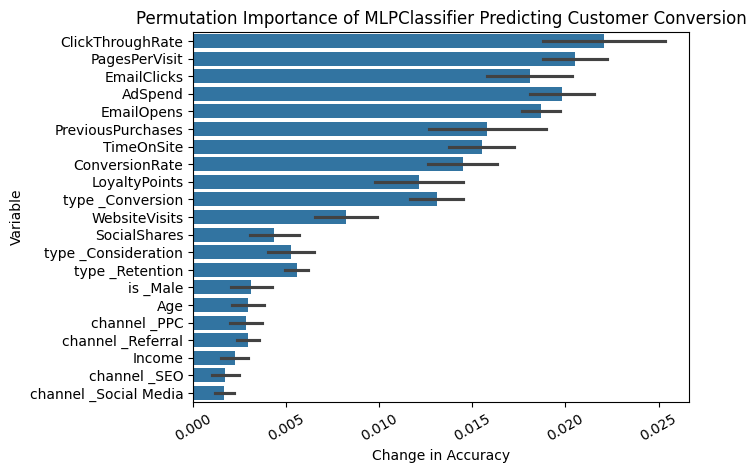

In [ ]:
from sklearn.inspection import permutation_importance

perm_import = permutation_importance(clf, X_train2, y_train,
                                     n_jobs=3,
                                     n_repeats = 10)

perm_import_df = pd.DataFrame(perm_import.importances.transpose(),
                                 columns = X_train2.columns.tolist())

perm_import_df_mlt = perm_import_df.melt(value_vars=X_train2.columns.tolist(),
                                         var_name='Variable',
                                         value_name='Importance').sort_values(by = 'Importance', ascending= False)
sns.barplot(data = perm_import_df_mlt,
            y = 'Variable',
            x = 'Importance',
            errorbar='sd')
plt.xlabel("Change in Accuracy")
plt.xticks(rotation = 30)
plt.title("Permutation Importance of MLPClassifier Predicting Customer Conversion");

### Save Neural Network Model

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/NN_model.p', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
"""with open('/content/drive/MyDrive/Colab Notebooks/MISY331/NN_model.p', 'wb') as f:
    pickle.dump(clf, f)"""